In [1]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.aamp)
"""
import pandas as pd
import ampiimts
import time

Best consensus window size(s): [(288, '24h', np.float32(0.018312242), np.float64(0.0)), (144, '12h', np.float32(0.021885766), np.float64(0.0)), (576, '48h', np.float32(0.022436354), np.float64(0.0))]
Best window sizes (hours): 24h, 12h, 48h


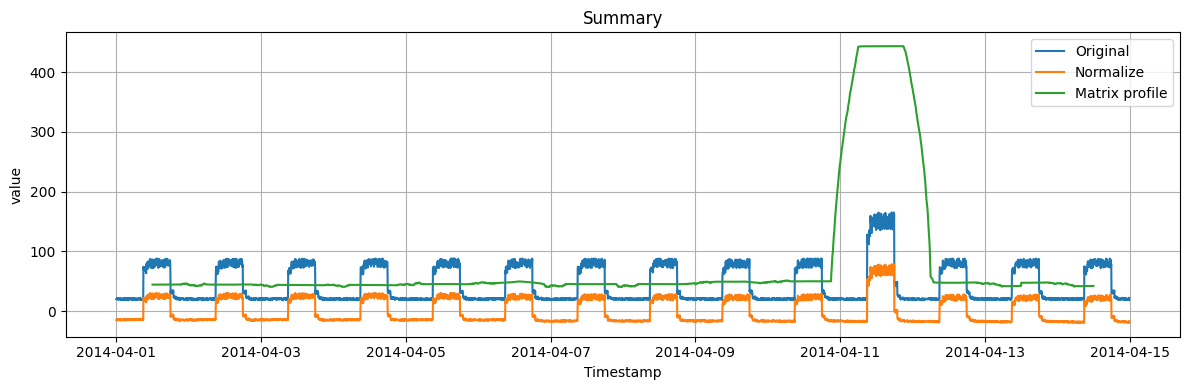

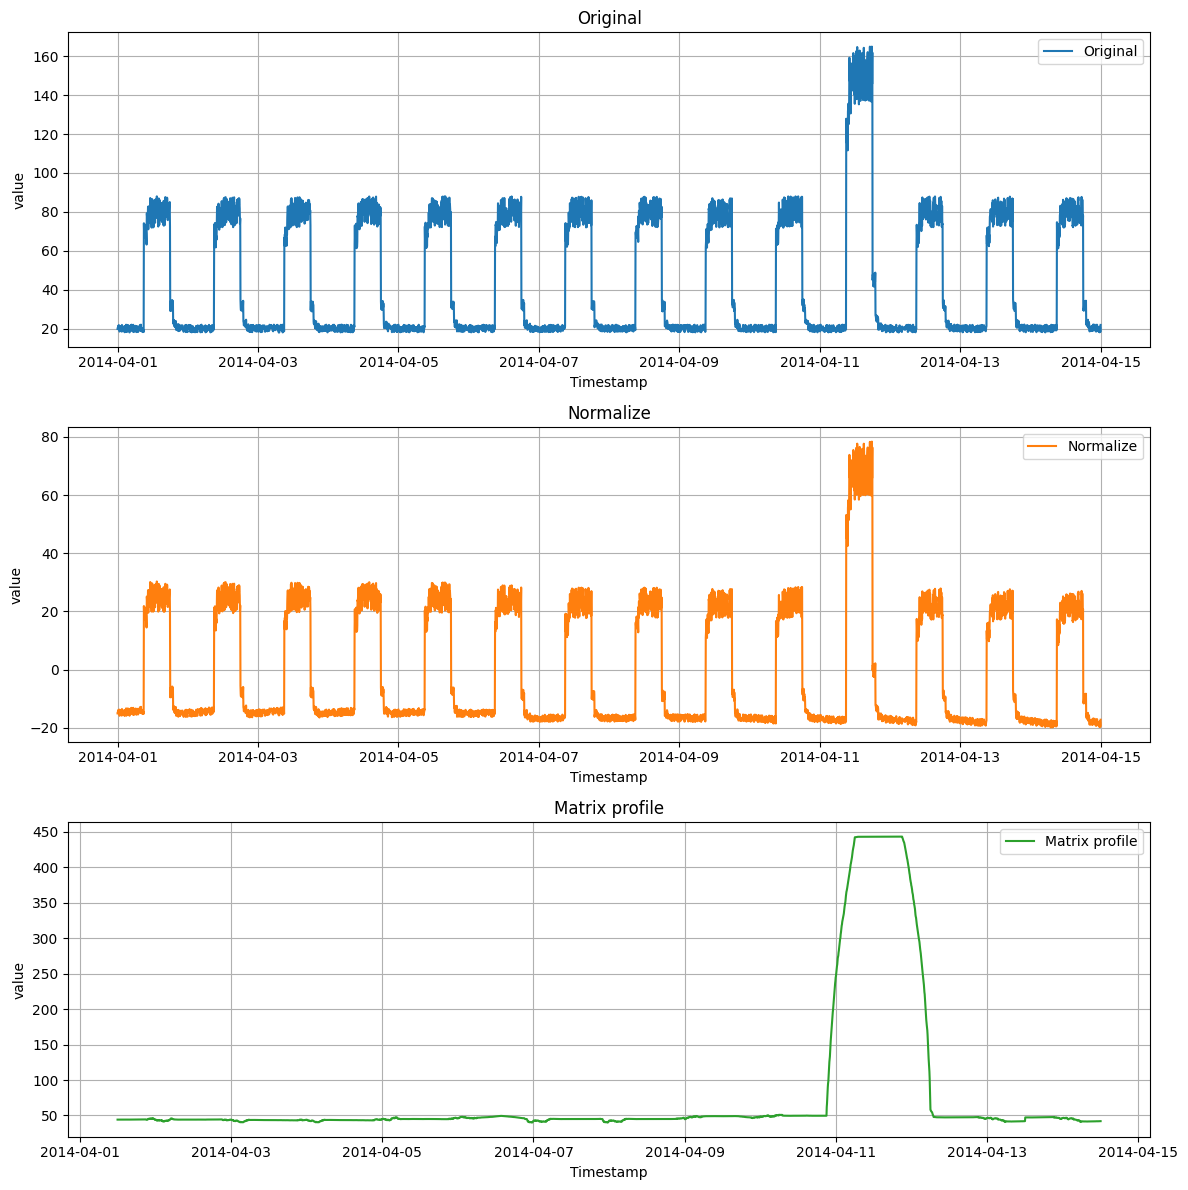

timing : 4.117691357001604


In [73]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/art_daily_jumpsup.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

/tmp/ipykernel_68987/2417760828.py:86: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


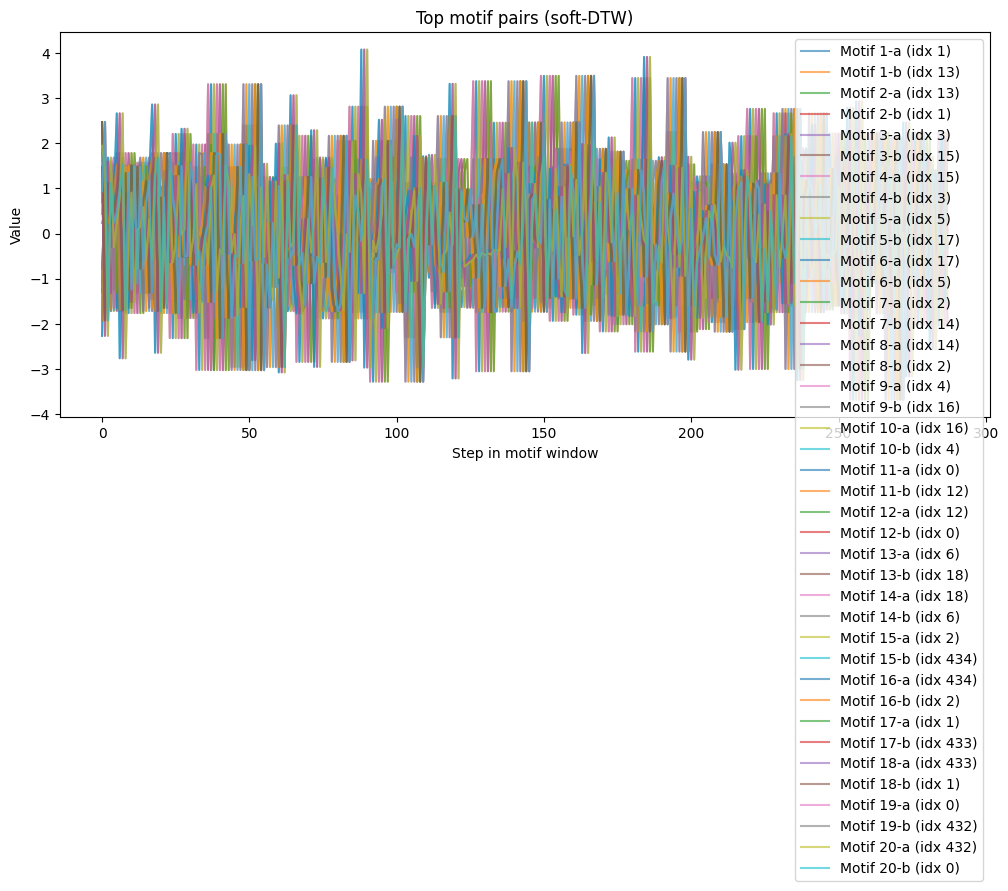

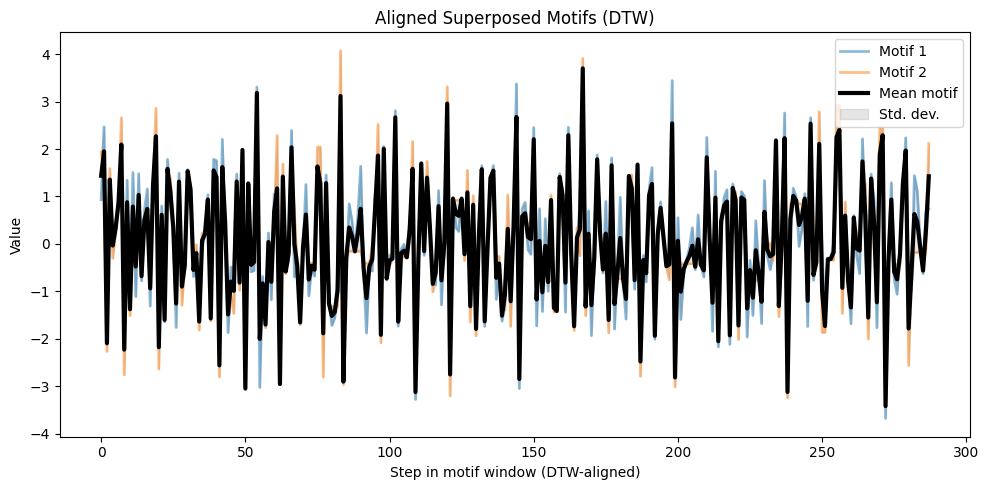

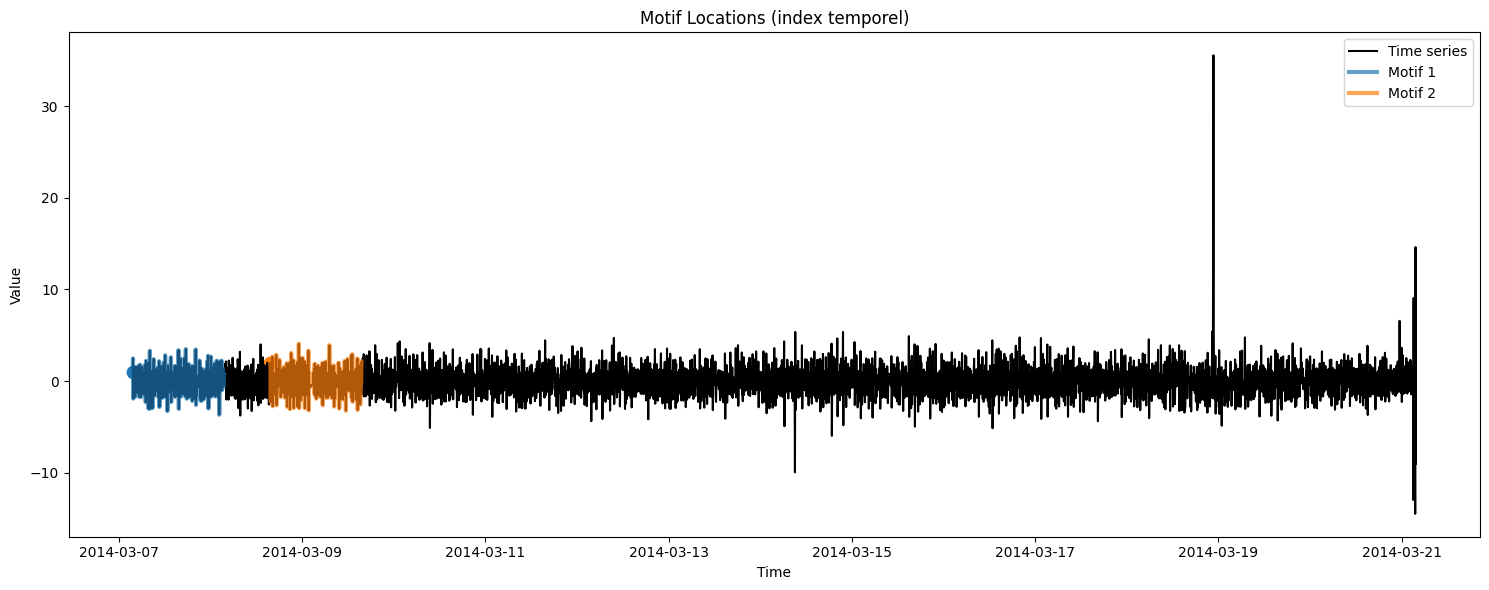

In [68]:
import numpy as np

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

def extract_all_windows(df, window_size):
    """
    Découpe la série en toutes les fenêtres possibles (non-overlapping ou overlapping).
    Retourne un array [n_windows, window_size]
    """
    values = df['value'].values
    n = len(values) - window_size + 1
    return np.array([values[i:i+window_size] for i in range(n)])

from tslearn.metrics import cdist_soft_dtw

def find_closest_motifs_softdtw(windows, top_k=5, gamma=1.0):
    """
    Trouve les paires de motifs les plus proches (en termes de soft-DTW).
    """
    # windows: shape (n_windows, window_size)
    D = cdist_soft_dtw(windows, gamma=gamma)
    # On ne garde que la partie triangulaire supérieure pour éviter les doublons
    triu_indices = np.triu_indices_from(D, k=1)
    # Trie les paires par distance croissante
    sorted_idx = np.argsort(D[triu_indices])
    motif_pairs = [(triu_indices[0][i], triu_indices[1][i], D[triu_indices[0][i], triu_indices[1][i]]) for i in sorted_idx[:top_k]]
    return motif_pairs

import faiss

def find_closest_motifs_faiss(windows, top_k=5):
    # FAISS index
    windows32 = windows.astype(np.float32)
    index = faiss.IndexFlatL2(windows.shape[1])
    index.add(windows32)
    D, I = index.search(windows32, top_k+1)
    # Pour chaque fenêtre, le plus proche (sauf elle-même)
    motif_pairs = []
    for i in range(len(windows)):
        for j in range(1, top_k+1):  # On saute le premier (c'est lui-même)
            motif_pairs.append((i, I[i, j], D[i, j]))
    motif_pairs = sorted(motif_pairs, key=lambda x: x[2])
    return motif_pairs[:top_k]

from tslearn.metrics import dtw_path
import numpy as np
import matplotlib.pyplot as plt

def align_motifs_dtw(motif_segments):
    """
    Aligne tous les motifs sur la grille du motif de référence (le premier), via le chemin DTW.
    """
    ref = motif_segments[0]
    aligned_segments = [ref]
    for motif in motif_segments[1:]:
        path, _ = dtw_path(ref, motif)
        # path: list of (i, j) tuples mapping ref[i] <-> motif[j]
        # Pour chaque index de la référence, trouve les points alignés du motif
        aligned = []
        for i in range(len(ref)):
            js = [j for ii, j in path if ii == i]
            aligned.append(np.mean([motif[j] for j in js]))  # moyenne si plusieurs alignés
        aligned_segments.append(aligned)
    return np.array(aligned_segments)


import matplotlib.pyplot as plt

def plot_best_motif_pairs(df, window_size, motif_pairs):
    """
    Affiche les motifs trouvés par soft-DTW en les superposant.
    """
    values = df['value'].values
    plt.figure(figsize=(12, 5))
    for i, (idx1, idx2, dist) in enumerate(motif_pairs):
        motif1 = values[idx1:idx1+window_size]
        motif2 = values[idx2:idx2+window_size]
        plt.plot(motif1, alpha=0.6, label=f"Motif {i+1}-a (idx {idx1})" )
        plt.plot(motif2, alpha=0.6, label=f"Motif {i+1}-b (idx {idx2})" )
    plt.title(f"Top motif pairs (soft-DTW)")
    plt.xlabel("Step in motif window")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_superposed_aligned_motifs_dtw(df, motif_idxs, window_size, title="Aligned Superposed Motifs (DTW)"):
    values = df['value'].values
    motif_segments = []
    for idx in motif_idxs:
        start = idx
        end = idx + window_size
        if end > len(values): continue
        motif_segments.append(values[start:end])
    motif_segments = np.array(motif_segments)
    aligned = align_motifs_dtw(motif_segments)
    t = np.arange(window_size)
    plt.figure(figsize=(10, 5))
    for i, seg in enumerate(aligned):
        plt.plot(t, seg, alpha=0.5, lw=2, label=f"Motif {i+1}" if i < 10 else None)
    if len(aligned) > 1:
        plt.plot(t, aligned.mean(axis=0), color='black', linewidth=3, label="Mean motif")
        plt.fill_between(
            t,
            aligned.mean(axis=0) - aligned.std(axis=0),
            aligned.mean(axis=0) + aligned.std(axis=0),
            color='gray', alpha=0.2, label='Std. dev.'
        )
    plt.title(title)
    plt.xlabel("Step in motif window (DTW-aligned)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_motif_locations_on_series(df, motif_idxs, window_size, title="Motif Locations on Series"):
    """
    Affiche la série temporelle complète et marque les positions des motifs extraits (sur l'axe temporel réel).
    """
    values = df['value'].values
    t = df.index  # DatetimeIndex ou RangeIndex
    
    plt.figure(figsize=(15, 6))
    plt.plot(t, values, color='black', label='Time series')
    
    # Marque chaque fenêtre motif
    for i, idx in enumerate(motif_idxs):
        start = idx
        end = idx + window_size
        if end > len(values): continue
        plt.plot(t[start:end], values[start:end], lw=3, alpha=0.7,
                 label=f"Motif {i+1}" if i < 8 else None)
        plt.scatter(t[start], values[start], s=80, marker='o')
    
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

def filter_non_overlapping_idxs(motif_idxs, window_size):
    """
    Retourne une liste d'indices non-overlapping, triés par ordre croissant.
    """
    motif_idxs_sorted = sorted(set(motif_idxs))
    filtered = []
    last_end = -1
    for idx in motif_idxs_sorted:
        if idx > last_end:
            filtered.append(idx)
            last_end = idx + window_size - 1
    return filtered


window_size = 288  # Par exemple
windows = extract_all_windows(df_normalize, window_size)
motif_pairs = find_closest_motifs_faiss(windows, top_k=20)
plot_best_motif_pairs(df_normalize, window_size, motif_pairs)
motif_idxs_raw = list(set([idx for pair in motif_pairs for idx in pair[:2]]))
motif_idxs = filter_non_overlapping_idxs(motif_idxs_raw, window_size)
plot_superposed_aligned_motifs_dtw(df_normalize, motif_idxs, window_size)
plot_motif_locations_on_series(df_normalize, motif_idxs, window_size, title="Motif Locations (index temporel)")


Extraction de toutes les fenêtres…
Clustering FAISS KMeans (euclidean)…
Sampling a subset of 1280 / 3745 for training
Clustering 1280 points in 288D to 5 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.00 s
  Iteration 24 (1.27 s, search 0.41 s): objective=5.63764e+07 imbalance=1.001 nsplit=0       
5 motifs (patterns) détectés (euclidean clusters).

Pattern #0 : 13 occurrences


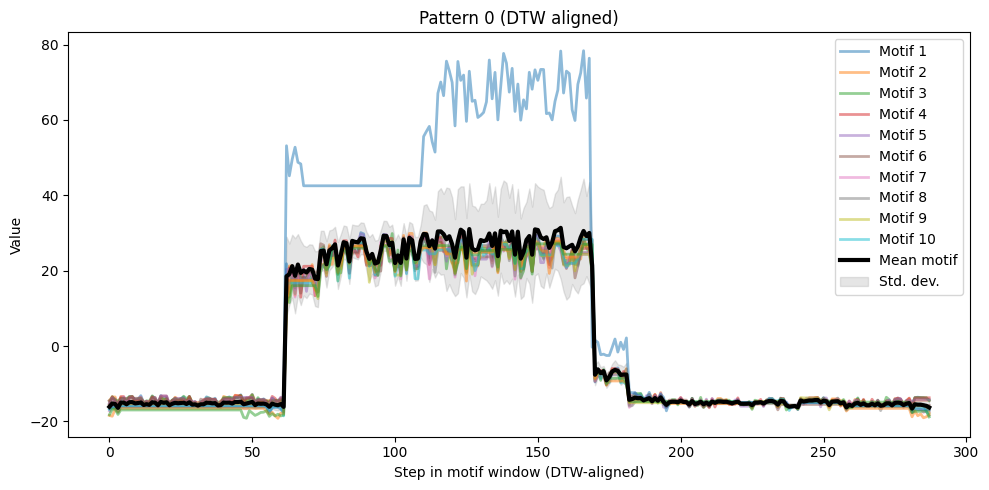

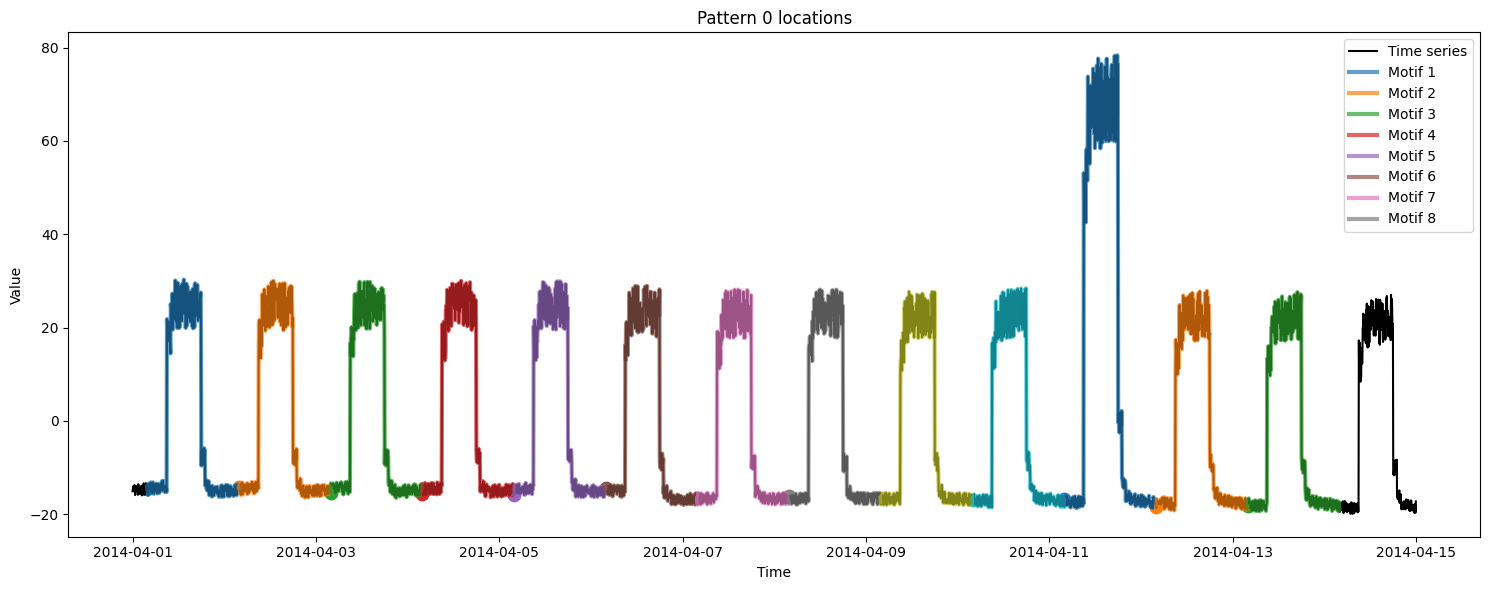


Pattern #1 : 13 occurrences


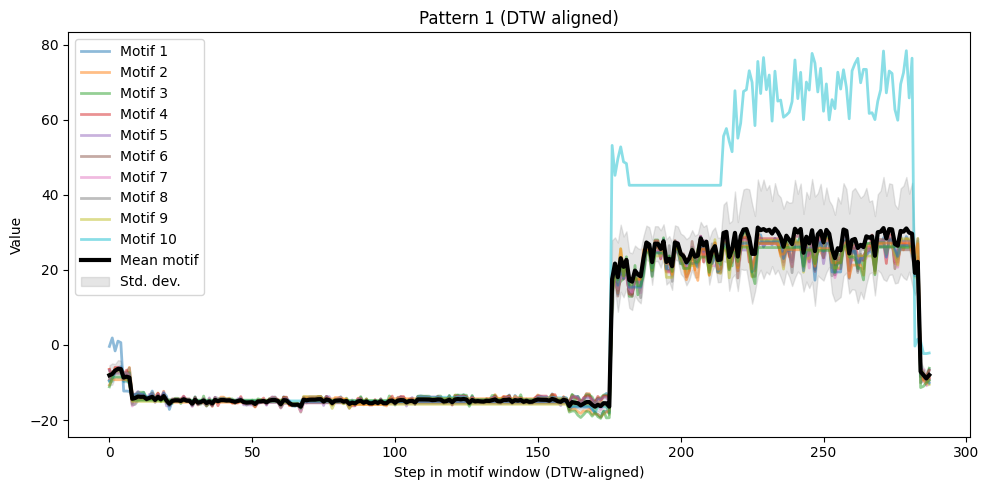

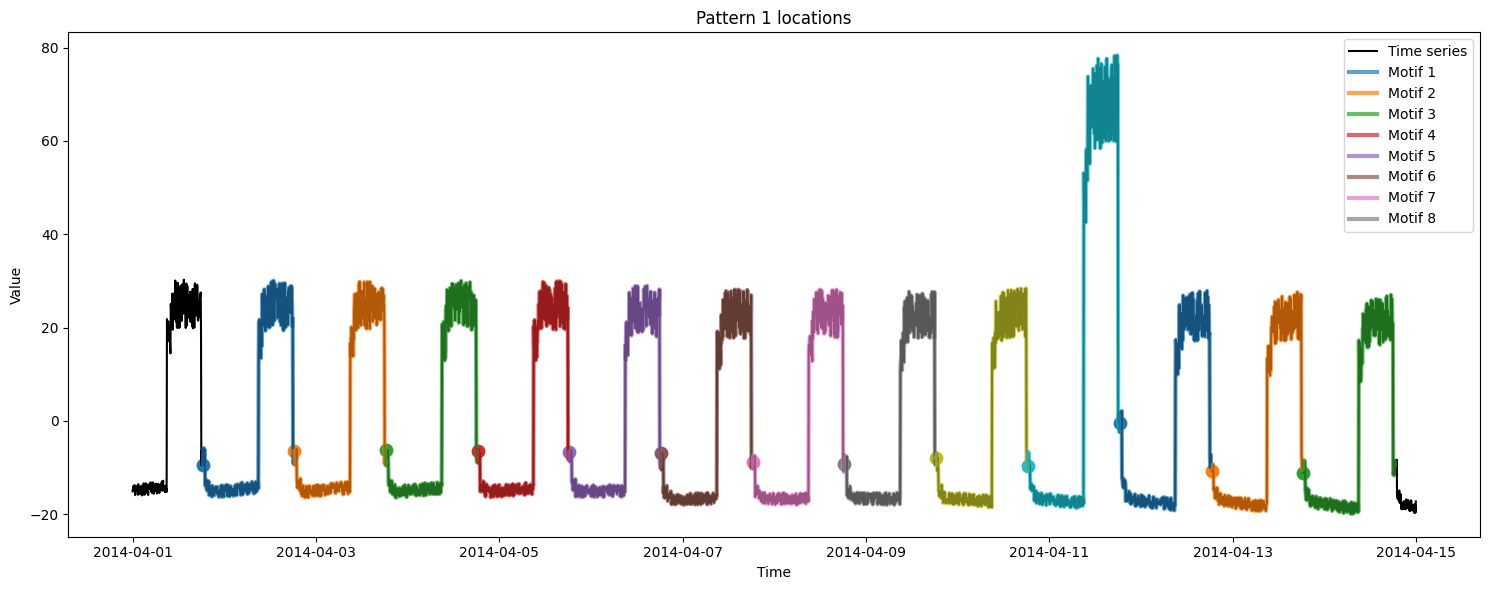


Pattern #2 : 13 occurrences


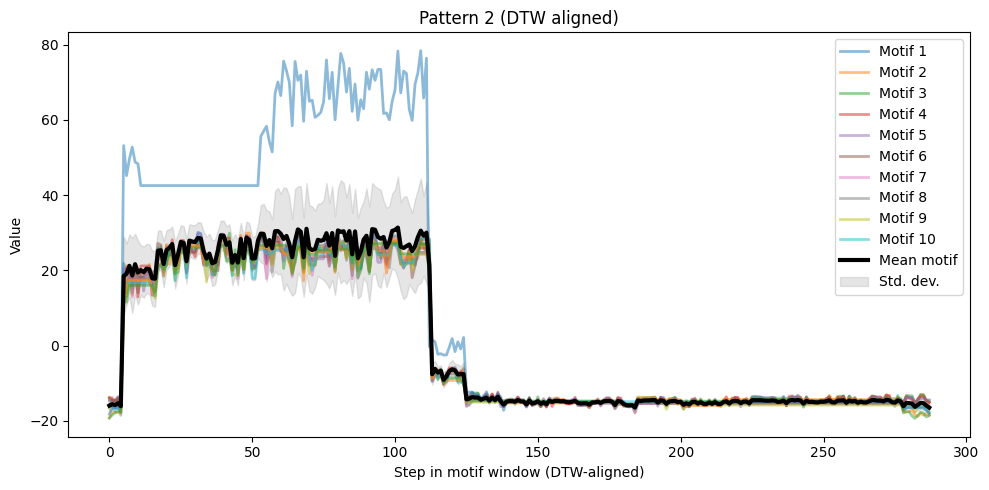

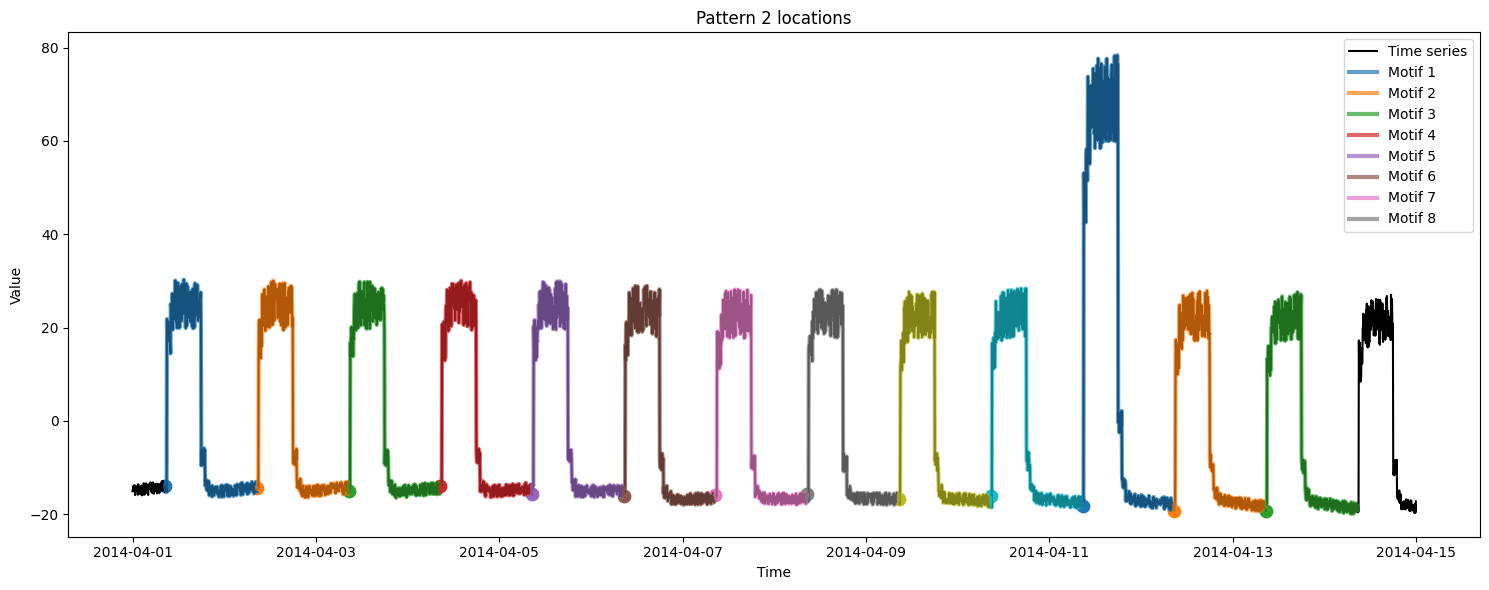


Pattern #3 : 14 occurrences


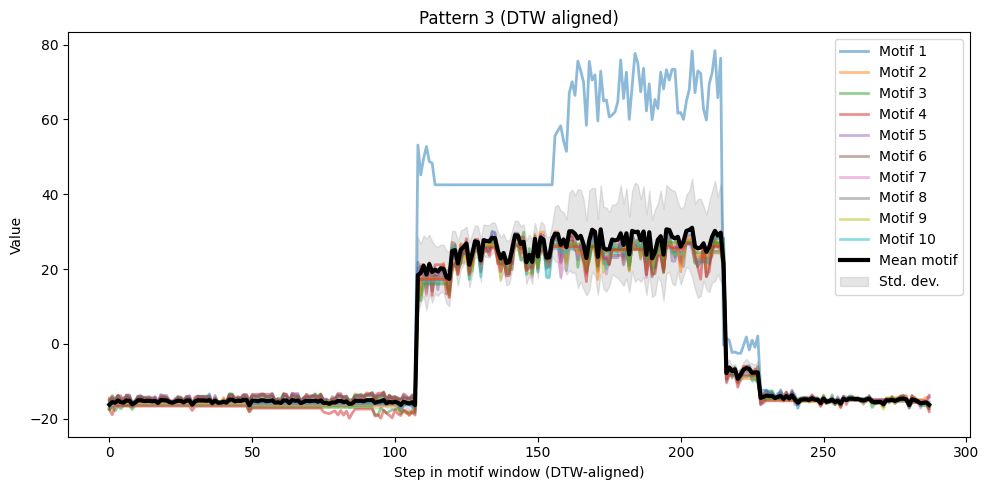

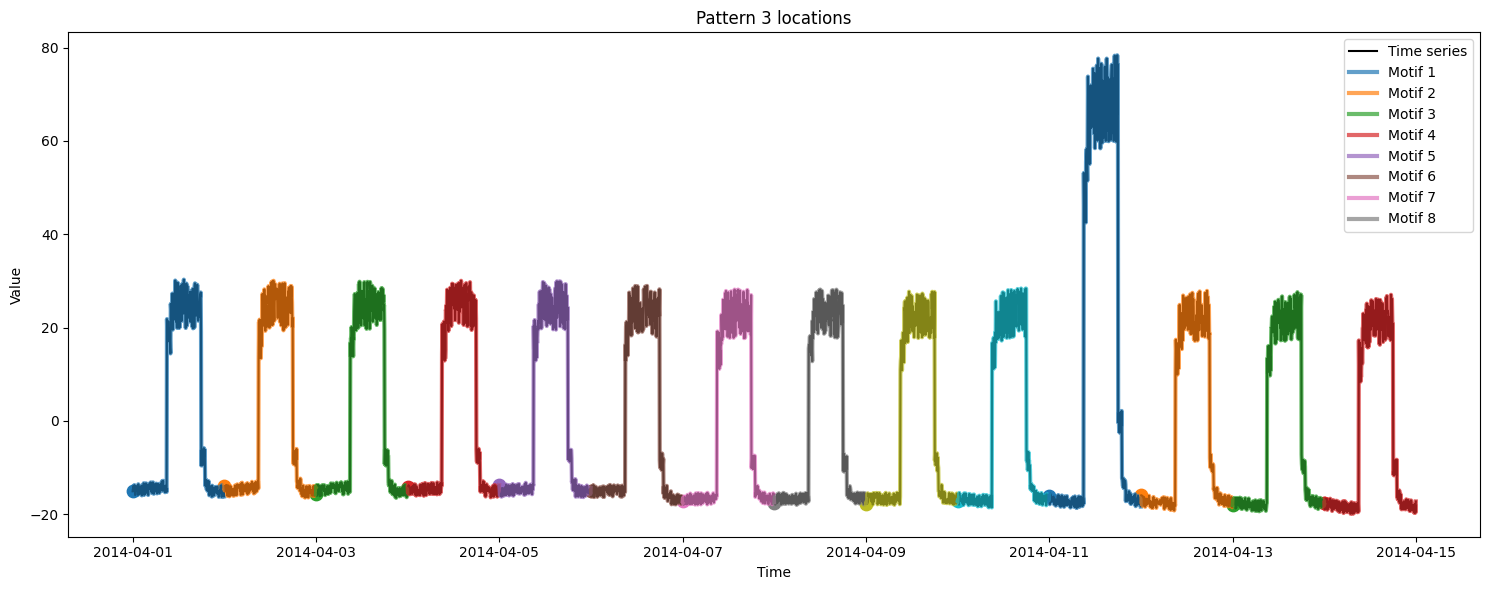


Pattern #4 : 13 occurrences


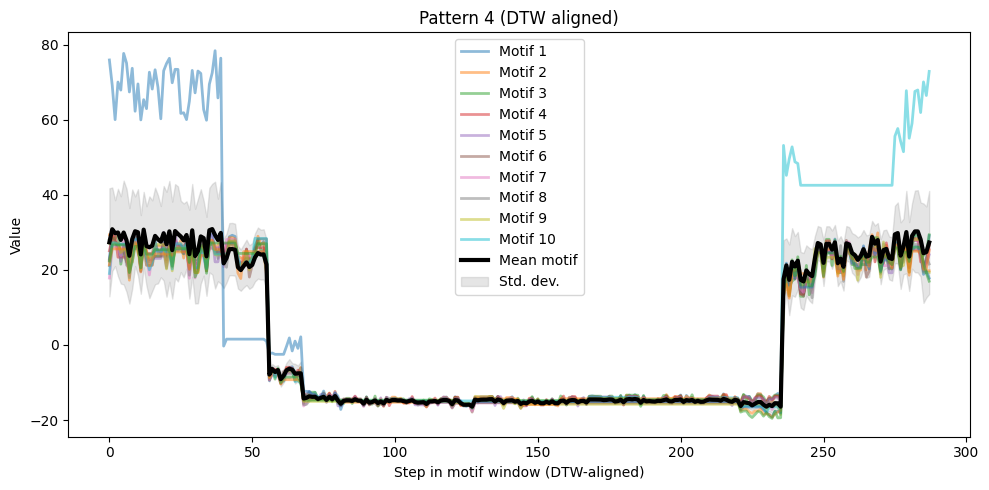

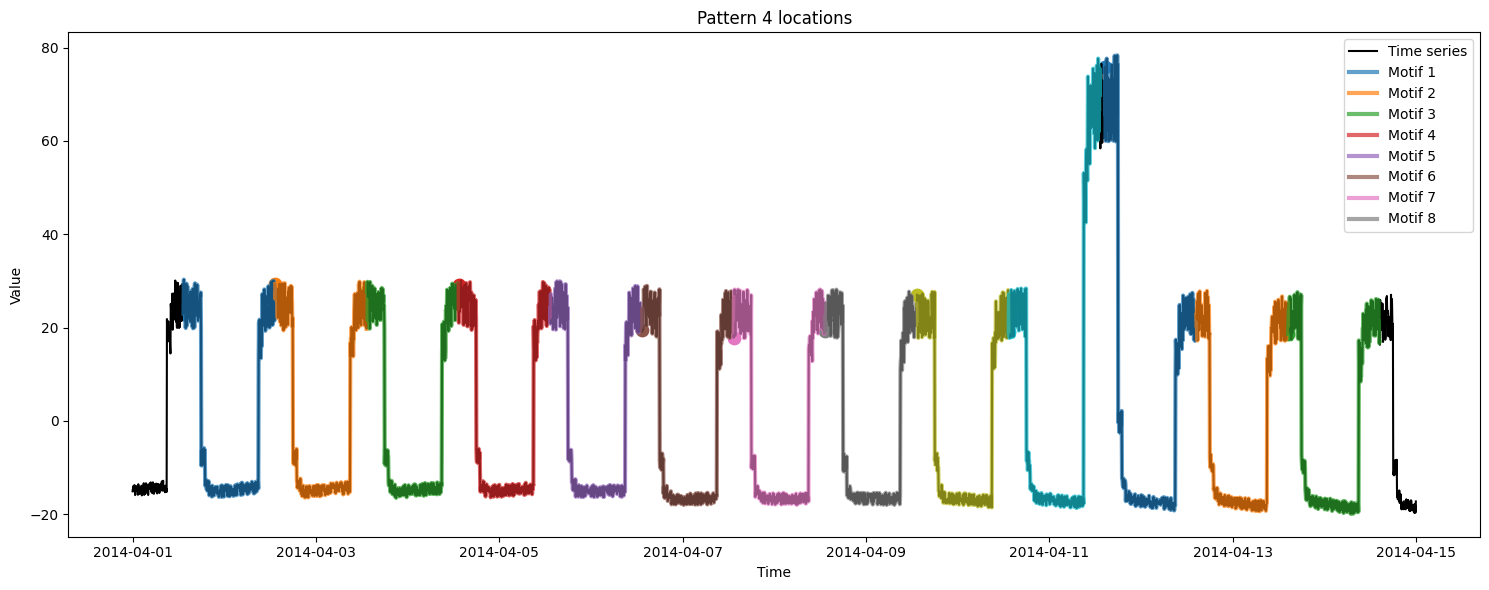

In [74]:
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from tslearn.metrics import dtw_path

# Extraction des fenêtres
def extract_all_windows(df, window_size):
    values = df['value'].values
    n = len(values) - window_size + 1
    return np.array([values[i:i+window_size] for i in range(n)])

# Suppression des motifs overlapping
def filter_non_overlapping_idxs(motif_idxs, window_size):
    motif_idxs_sorted = sorted(set(motif_idxs))
    filtered = []
    last_end = -1
    for idx in motif_idxs_sorted:
        if idx > last_end:
            filtered.append(idx)
            last_end = idx + window_size - 1
    return filtered

# Alignement DTW
def align_motifs_dtw(motif_segments):
    ref = motif_segments[0]
    aligned_segments = [ref]
    for motif in motif_segments[1:]:
        path, _ = dtw_path(ref, motif)
        aligned = []
        for i in range(len(ref)):
            js = [j for ii, j in path if ii == i]
            aligned.append(np.mean([motif[j] for j in js]))
        aligned_segments.append(aligned)
    return np.array(aligned_segments)

# Plot superposé aligné DTW
def plot_superposed_aligned_motifs_dtw(df, motif_idxs, window_size, title="Aligned Superposed Motifs (DTW)"):
    values = df['value'].values
    motif_segments = []
    for idx in motif_idxs:
        start = idx
        end = idx + window_size
        if end > len(values): continue
        motif_segments.append(values[start:end])
    if len(motif_segments) == 0:
        print(f"No motifs for this cluster.")
        return
    motif_segments = np.array(motif_segments)
    aligned = align_motifs_dtw(motif_segments)
    t = np.arange(window_size)
    plt.figure(figsize=(10, 5))
    for i, seg in enumerate(aligned):
        plt.plot(t, seg, alpha=0.5, lw=2, label=f"Motif {i+1}" if i < 10 else None)
    if len(aligned) > 1:
        plt.plot(t, aligned.mean(axis=0), color='black', linewidth=3, label="Mean motif")
        plt.fill_between(
            t,
            aligned.mean(axis=0) - aligned.std(axis=0),
            aligned.mean(axis=0) + aligned.std(axis=0),
            color='gray', alpha=0.2, label='Std. dev.'
        )
    plt.title(title)
    plt.xlabel("Step in motif window (DTW-aligned)")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot sur la série complète
def plot_motif_locations_on_series(df, motif_idxs, window_size, title="Motif Locations on Series"):
    values = df['value'].values
    t = df.index
    plt.figure(figsize=(15, 6))
    plt.plot(t, values, color='black', label='Time series')
    for i, idx in enumerate(motif_idxs):
        start = idx
        end = idx + window_size
        if end > len(values): continue
        plt.plot(t[start:end], values[start:end], lw=3, alpha=0.7,
                 label=f"Motif {i+1}" if i < 8 else None)
        plt.scatter(t[start], values[start], s=80, marker='o')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Regrouper motifs par cluster
def get_cluster_indices(labels, window_size, min_size=2):
    clusters = {}
    for label in np.unique(labels):
        idxs = np.where(labels == label)[0]
        idxs_filtered = filter_non_overlapping_idxs(idxs, window_size)
        if len(idxs_filtered) >= min_size:
            clusters[label] = idxs_filtered
    return clusters

# FAISS KMeans clustering (ultra rapide)
def faiss_kmeans(windows, n_clusters, n_iter=20, verbose=True):
    d = windows.shape[1]
    windows32 = windows.astype(np.float32)
    kmeans = faiss.Kmeans(d, n_clusters, niter=n_iter, verbose=verbose, gpu=False)
    kmeans.train(windows32)
    _, labels = kmeans.index.search(windows32, 1)
    labels = labels.ravel()
    return labels

# Pipeline principal
def discover_patterns_faiss_kmeans(df, window_size, n_clusters=3, min_cluster_size=2, scale_windows=False):
    print("Extraction de toutes les fenêtres…")
    windows = extract_all_windows(df, window_size)
    if scale_windows:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        windows = scaler.fit_transform(windows)
    print("Clustering FAISS KMeans (euclidean)…")
    labels = faiss_kmeans(windows, n_clusters=n_clusters, n_iter=25, verbose=True)
    clusters = get_cluster_indices(labels, window_size, min_size=min_cluster_size)
    print(f"{len(clusters)} motifs (patterns) détectés (euclidean clusters).")
    for label, idxs in clusters.items():
        print(f"\nPattern #{label} : {len(idxs)} occurrences")
        plot_superposed_aligned_motifs_dtw(df, idxs, window_size, title=f"Pattern {label} (DTW aligned)")
        plot_motif_locations_on_series(df, idxs, window_size, title=f"Pattern {label} locations")
    return clusters

# -----------------------------
# Utilisation
# -----------------------------
window_size = 288  # à adapter à ta série
n_clusters = 5     # à ajuster pour explorer plusieurs patterns
clusters = discover_patterns_faiss_kmeans(df_normalize, window_size, n_clusters=n_clusters, min_cluster_size=2, scale_windows=False)



Best consensus window size(s): [(24, '12h', np.float32(0.020967642), np.float64(0.0)), (48, '24h', np.float32(0.028910795), np.float64(0.0)), (96, '48h', np.float32(0.036973637), np.float64(0.0))]
Best window sizes (hours): 12h, 24h, 48h


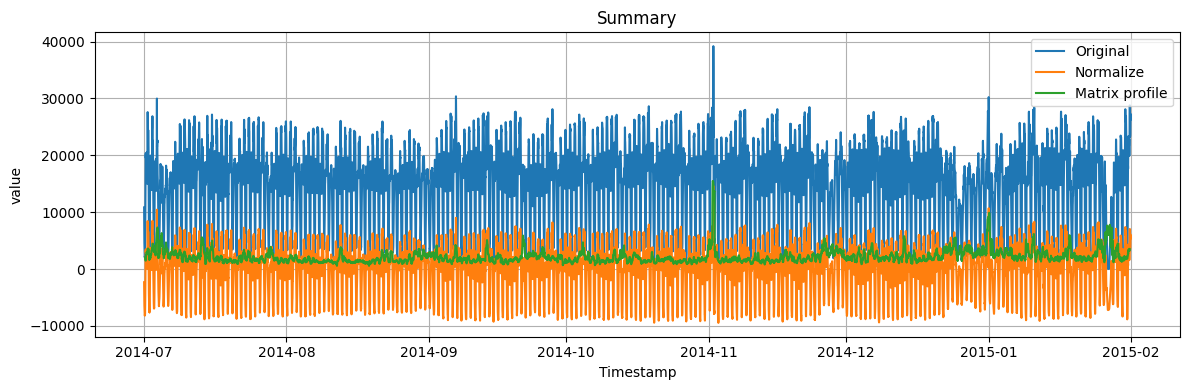

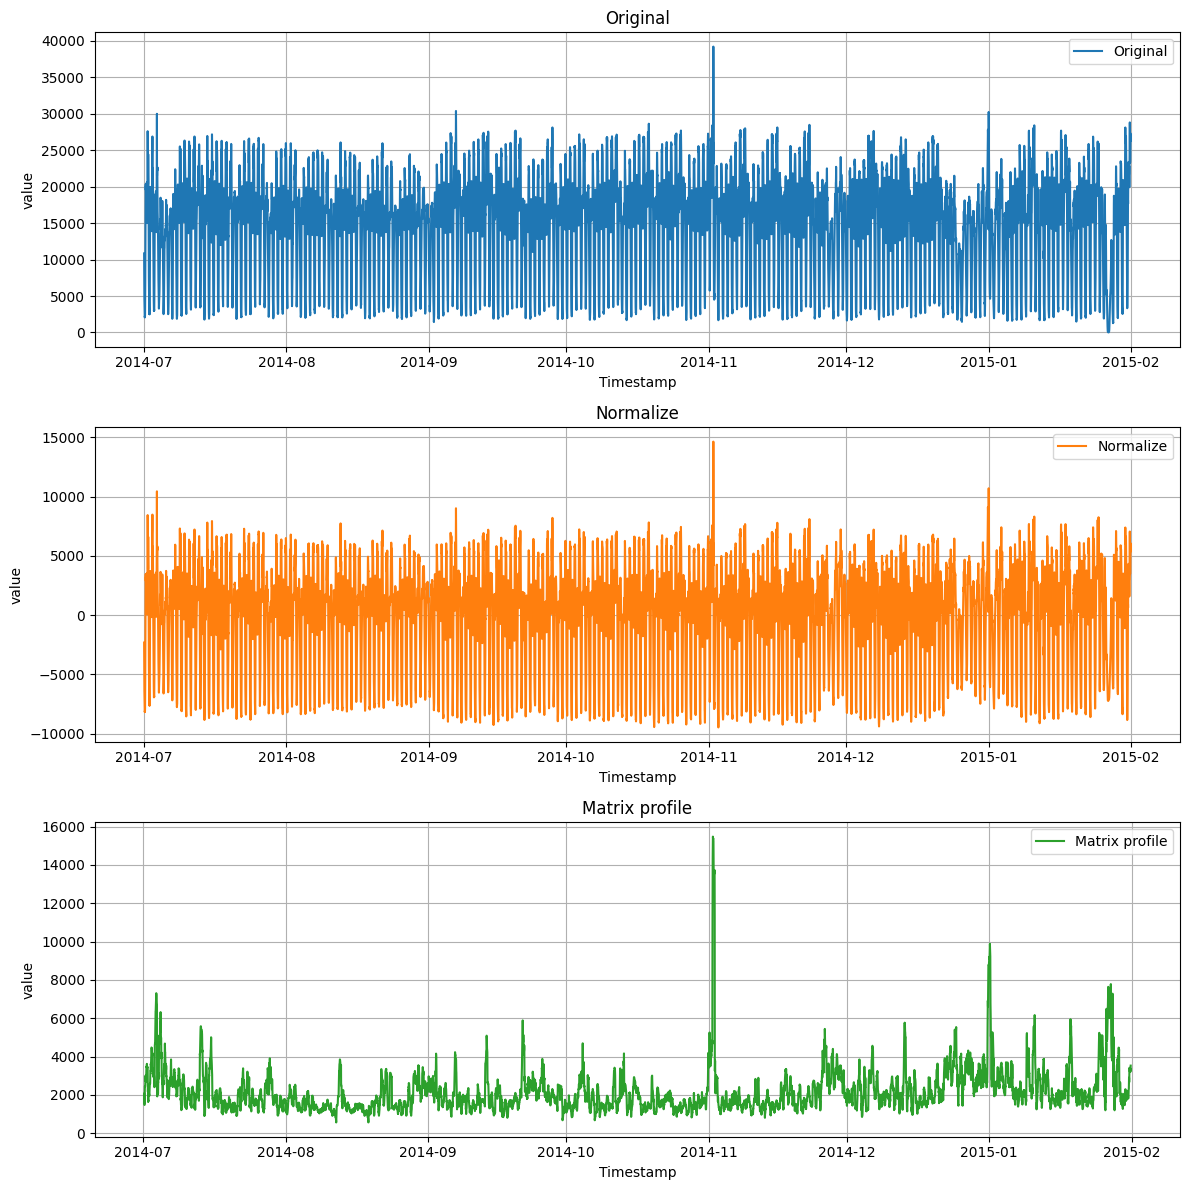

timing : 5.788768631999119


In [71]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/nyc_taxi.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best consensus window size(s): [(12, '1h', np.float32(0.19828956), np.float64(0.002005515166708448)), (36, '3h', np.float32(0.67228645), np.float64(0.0)), (144, '12h', np.float32(1.2192366), np.float64(0.0))]
Best window sizes (hours): 1h, 3h, 12h


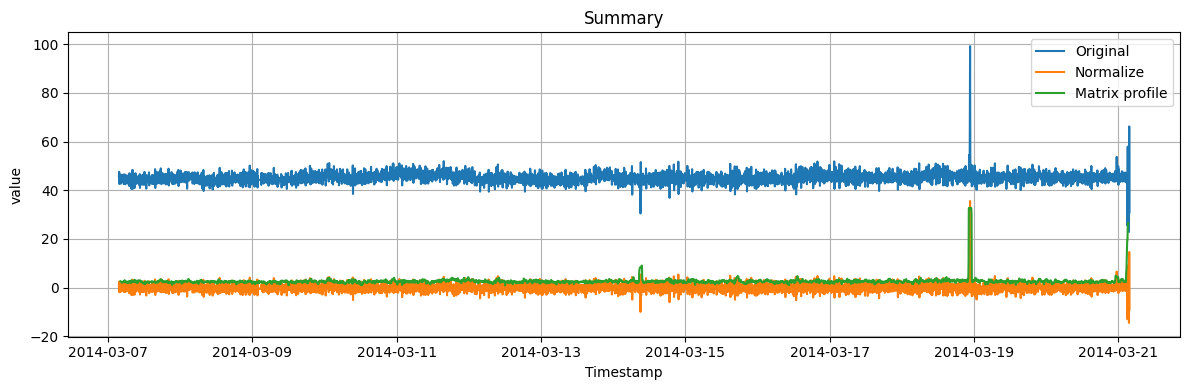

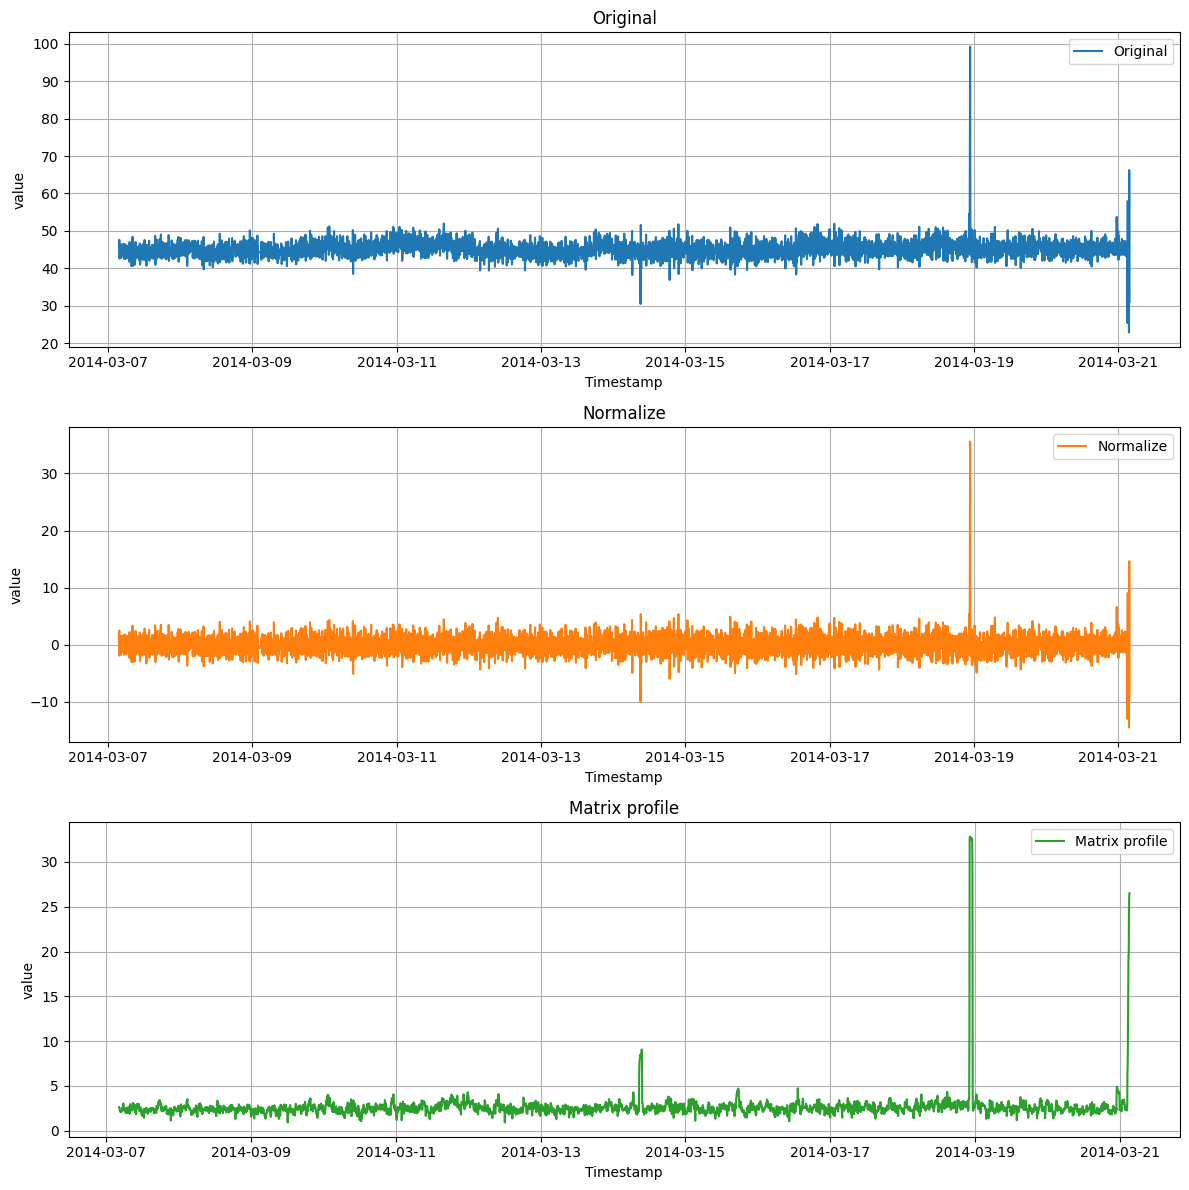

timing : 3.689241773001413


In [67]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/ec2_request_latency_system_failure.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best consensus window size(s): [(12, '12h', np.float32(0.12947273), np.float64(0.00250689395838556)), (24, '24h', np.float32(0.25154877), np.float64(0.0)), (48, '48h', np.float32(0.32792044), np.float64(0.0))]
Best window sizes (hours): 12h, 24h, 48h


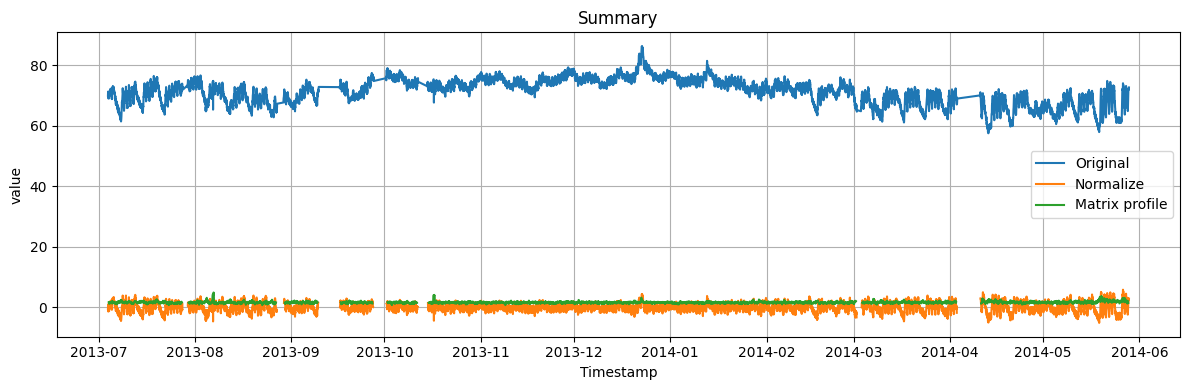

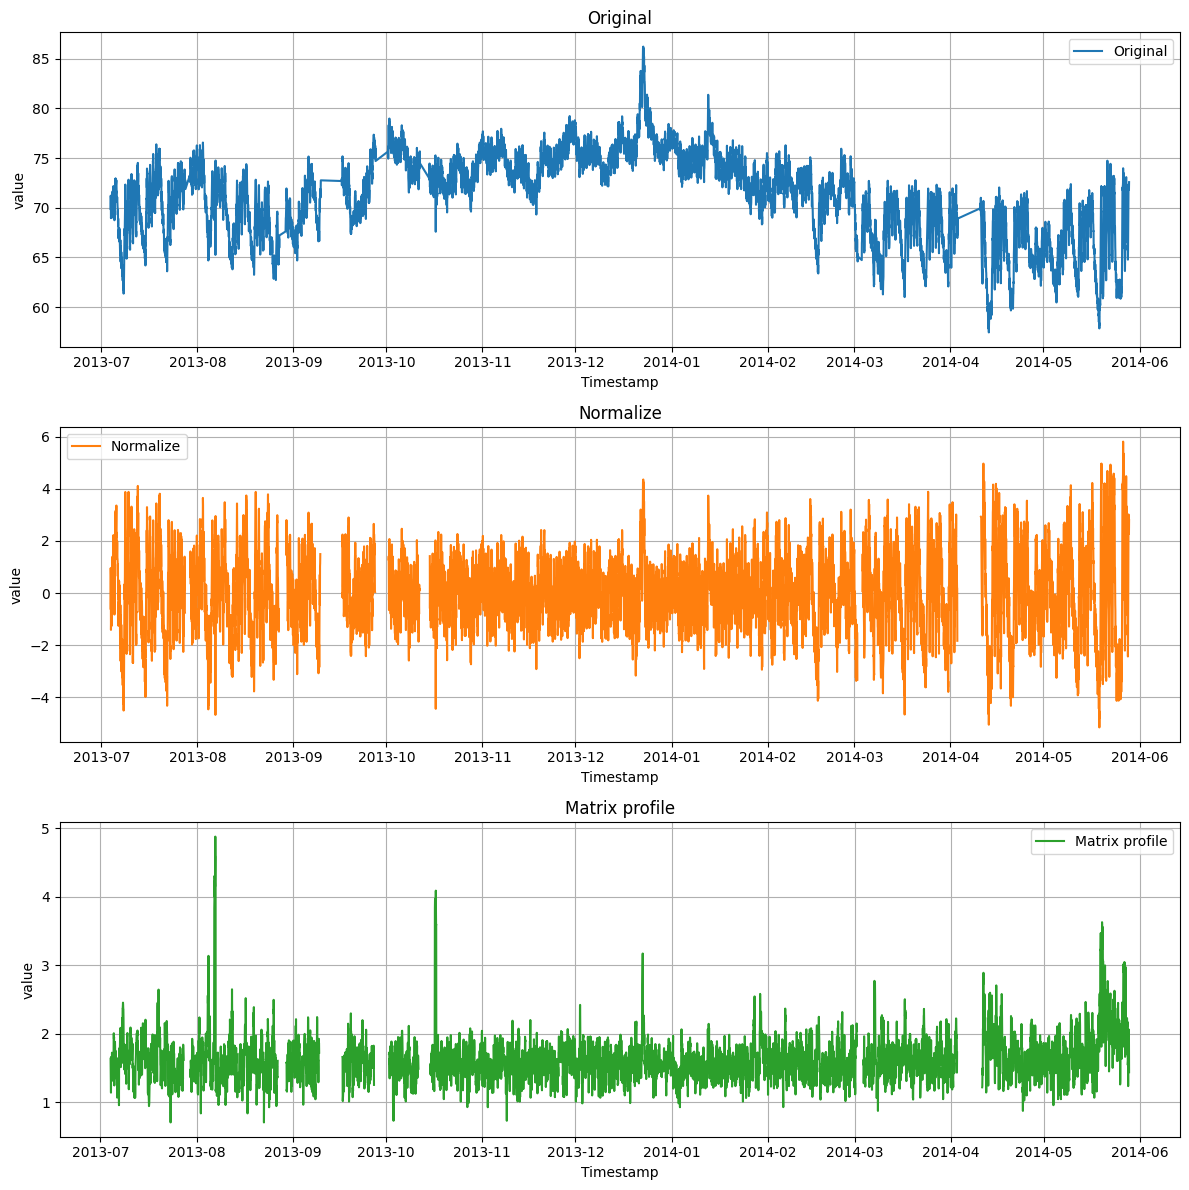

timing : 2.669821100997069


In [5]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/ambient_temperature_system_failure.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best consensus window size(s): [(12, '1h', np.float32(0.0047810874), np.float64(0.0752068187515668)), (36, '3h', np.float32(0.03304227), np.float64(0.0025220680958385876)), (144, '12h', np.float32(0.14788204), np.float64(0.0))]
Best window sizes (hours): 1h, 3h, 12h


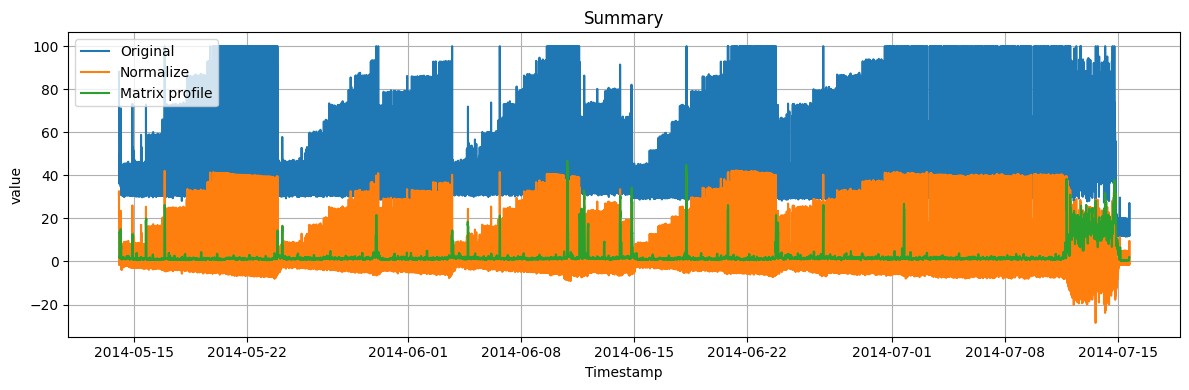

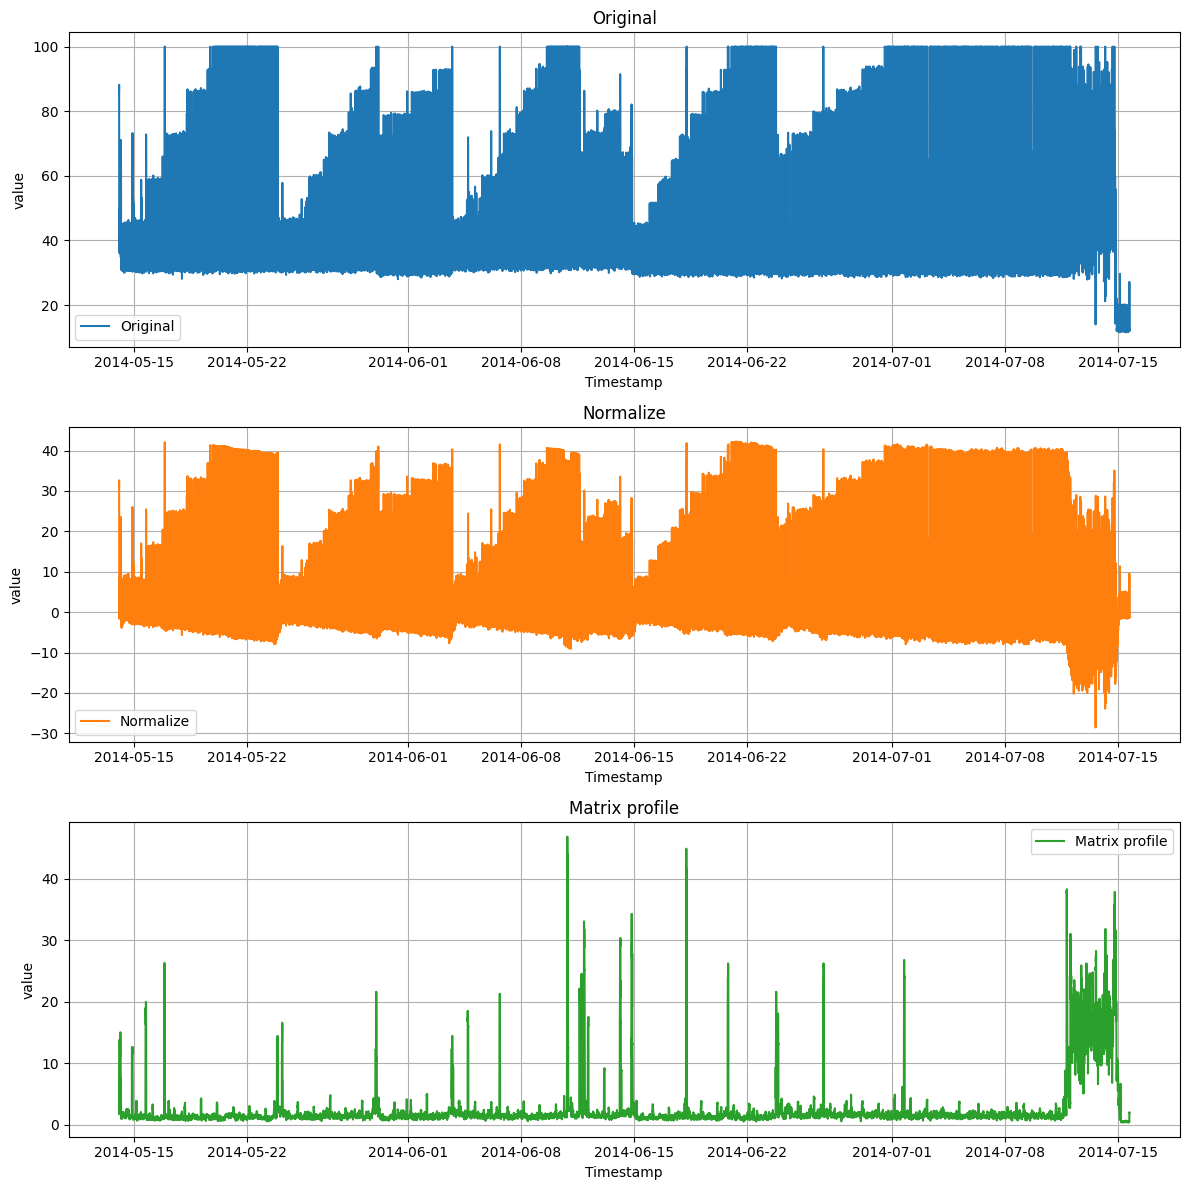

timing : 5.810490623000078


In [6]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/cpu_utilization_asg_misconfiguration.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")

Best consensus window size(s): [(12, '1h', np.float32(0.27266678), np.float64(0.01830032589621459)), (36, '3h', np.float32(0.7534343), np.float64(0.0)), (144, '12h', np.float32(0.86264515), np.float64(0.0))]
Best window sizes (hours): 1h, 3h, 12h


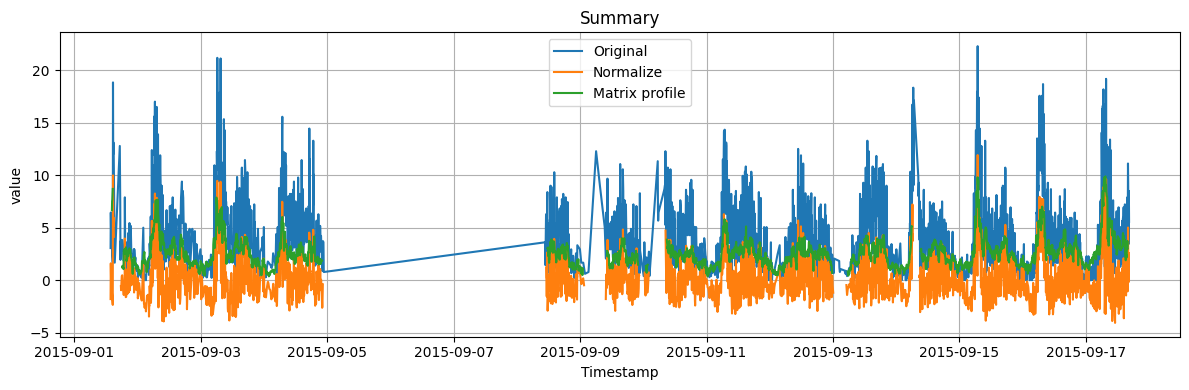

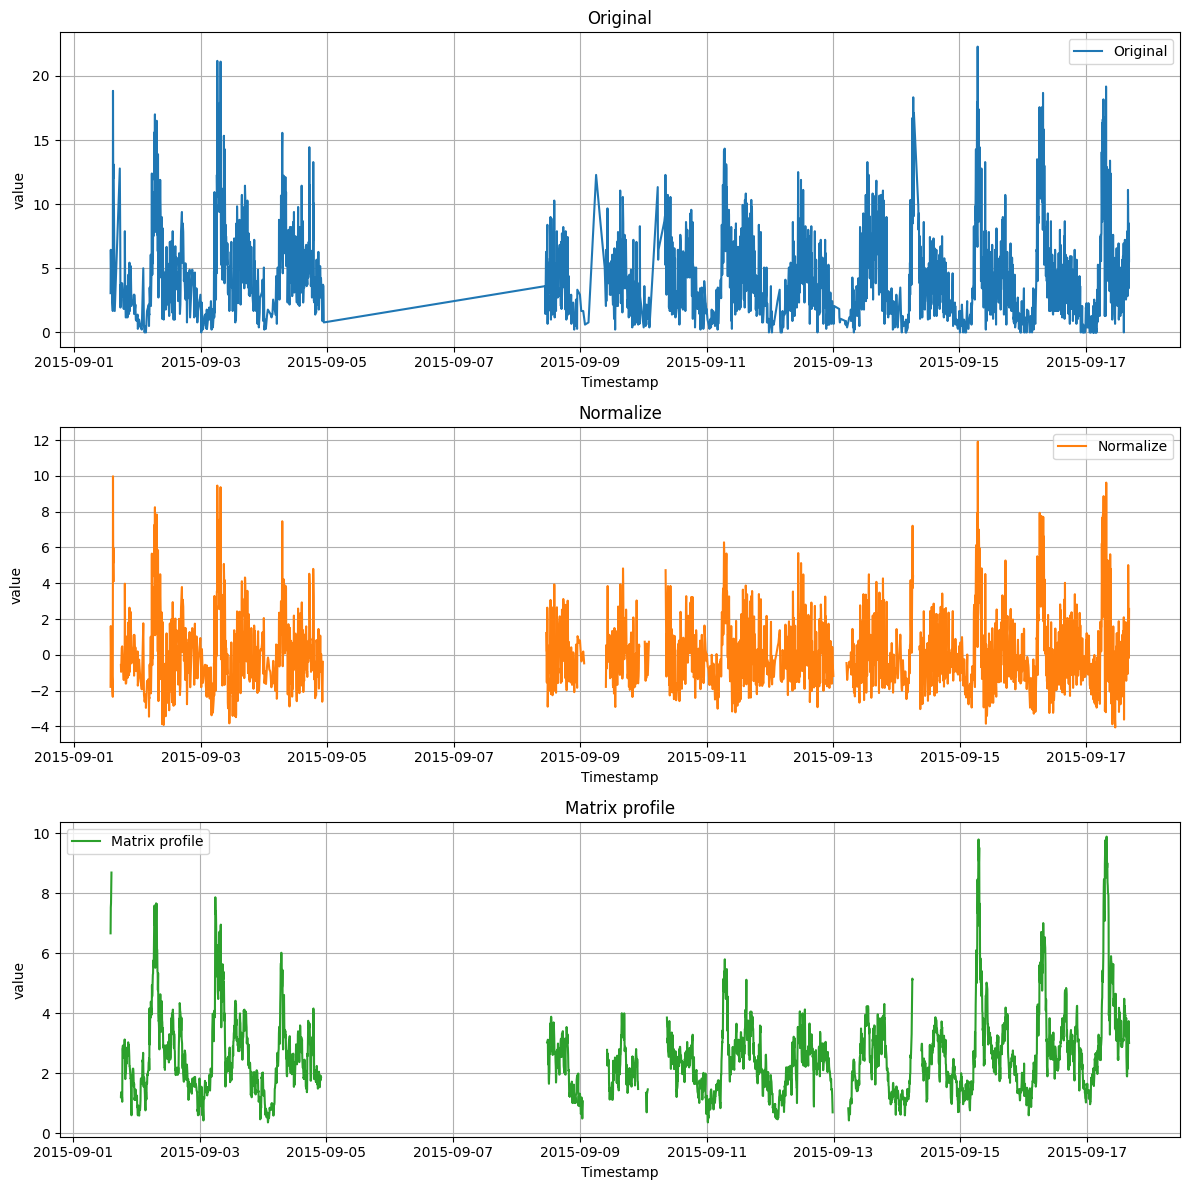

timing : 2.755729954002163


In [7]:
# --- import of CSV file ---
start_time = time.perf_counter()

# get original dataframe
df = pd.read_csv('../../dataset/occupancy_6005.csv')
df_normalize = ampiimts.pre_processed(df)
df_profile = ampiimts.matrix_profile(df_normalize)
ampiimts.plot_multiple_dfs([df, df_normalize, df_profile], ['Original', 'Normalize', 'Matrix profile'], column='value')
end_time = time.perf_counter()
print(f"timing : {end_time - start_time}")